# **How to plot multiple waveforms in a single picture**
This notebook provides some example to select waveform data according to the metadata provided. 

This has been used to generate figures 14, 15, 16 and 20 of the article....

In [1]:
import string
import argparse as ap
import sys
import os
import numpy as np

import obspy
import obspy.core as oc
from obspy import read_inventory

# from datetime import datetime, timedelta
import time

import pylab as plt
import pandas as pd
import h5py


import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.dates import date2num
from matplotlib.lines import Line2D
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
import datetime

mpl.rcParams['pdf.fonttype'] = 42

## Define the path to metadata and hdf5 files

In [2]:
# directory PATH
METADIR = '../metadata'
HDFDIR = '../data'
FIGDIR='../output'

# file NAMES
# MetaData
events_metaname=os.path.join(METADIR,'metadata_Instance_events_10k.csv') # Either Counts and GroundMotion
noise_metaname=os.path.join(METADIR,'metadata_Instance_noise_1k.csv')
# HDF5
events_hdfname=os.path.join(HDFDIR,'Instance_events_counts_10k.hdf5')
gm_hdfname=os.path.join(HDFDIR,'Instance_events_gm_10k.hdf5')
noise_hdfname=os.path.join(HDFDIR,'Instance_noise_1k.hdf5')
# Figures
# events_figname=os.path.join(FIGDIR,'waveforms_Evs.png')
# gm_figname=os.path.join(FIGDIR,'waveforms_Evs_gm.png')
# noise_figname=os.path.join(FIGDIR,'waveforms_Noise.png')

## Read metadata for events and noise

In [3]:
events_metaData = pd.read_csv(events_metaname, keep_default_na=False, dtype={'station_location_code': object, 
           'source_mt_eval_mode':object,'source_mt_status': object,'source_mechanism_strike_dip_rake': object, 
           'source_mechanism_moment_tensor': object, 'trace_p_arrival_time': object, 'trace_s_arrival_time': object})

/homes/cianetti/.conda/envs/gpd/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (57,58,62,75,76,77,79,87,95,103) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
noise_metaData = pd.read_csv(noise_metaname,dtype={'station_location_code': object})

## You can also read bz2 directly

In [5]:
# events_metaname_bz2 = os.path.join(METADIR,'events.csv.bz2')
# events_metaData = pd.read_csv(events_metaname_bz2, keep_default_na=False, dtype={'station_location_code': object, 
#            'source_mt_eval_mode':object,'source_mt_status': object,'source_mechanism_strike_dip_rake': object, 
#            'source_mechanism_moment_tensor': object, 'trace_p_arrival_time': object, 'trace_s_arrival_time': object})

## Read Waveforms hdf5 files

In [6]:
events_h5File = h5py.File(events_hdfname, 'r') # Events in counts
gm_h5File = h5py.File(gm_hdfname, 'r')         # Events in ground motion units
noise_h5File = h5py.File(noise_hdfname, 'r')   # Noise in counts

## Load plot function

In [7]:
sys.path.append('./Def_plot_waveform.py')

In [8]:
from Def_plot_waveform import split, build_stream, multiple_streams

## Figure labels

In [9]:
fignumbers = 'abcdefghijklmnopqrstuvwxyz'
alllabs = split(fignumbers)

## Here is the list of available metadata for events

In [10]:
events_metaData.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 117 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Unnamed: 0                        10000 non-null  int64  
 1   source_id                         10000 non-null  int64  
 2   station_network_code              10000 non-null  object 
 3   station_code                      10000 non-null  object 
 4   station_location_code             10000 non-null  object 
 5   station_channels                  10000 non-null  object 
 6   station_latitude_deg              10000 non-null  float64
 7   station_longitude_deg             10000 non-null  float64
 8   station_elevation_m               10000 non-null  float64
 9   station_vs_30                     10000 non-null  float64
 10  station_vs_30_detail              10000 non-null  object 
 11  source_origin_time                10000 non-null  object 
 12  sour

## Here is the list of available metadata for noise

In [11]:
noise_metaData.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 46 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   source_id                      1000 non-null   object 
 1   station_network_code           1000 non-null   object 
 2   station_code                   1000 non-null   object 
 3   station_location_code          13 non-null     object 
 4   station_channels               1000 non-null   object 
 5   station_latitude_deg           1000 non-null   float64
 6   station_longitude_deg          1000 non-null   float64
 7   station_elevation_m            1000 non-null   float64
 8   station_vs_30                  1000 non-null   float64
 9   station_vs_30_detail           1000 non-null   object 
 10  trace_start_time               1000 non-null   object 
 11  trace_dt                       1000 non-null   float64
 12  trace_npts                     1000 non-null   in

## Convert argument of metadata columns with different type to numeric.

In [19]:
list_ch=['trace_E_min_counts','trace_N_min_counts','trace_Z_min_counts',
         'trace_E_max_counts','trace_N_max_counts','trace_Z_max_counts',
         'trace_E_median_counts','trace_N_median_counts','trace_Z_median_counts',
         'trace_E_mean_counts','trace_N_mean_counts','trace_Z_mean_counts',
         'trace_E_pga_perc','trace_N_pga_perc','trace_Z_pga_perc',
         'trace_E_pga_cmps2','trace_N_pga_cmps2','trace_Z_pga_cmps2',
         'trace_E_pgv_cmps','trace_N_pgv_cmps','trace_Z_pgv_cmps',
         'trace_E_snr_db','trace_N_snr_db','trace_Z_snr_db',
         'trace_E_sa03_cmps2','trace_N_sa03_cmps2','trace_Z_sa03_cmps2',
         'trace_pgv_cmps', 'trace_pga_perc',
         'trace_EQT_number_detections','trace_EQT_P_number','trace_EQT_S_number','trace_GPD_P_number','trace_GPD_S_number']

In [20]:
for ele in list_ch:
    events_metaData[ele] =  pd.to_numeric(events_metaData[ele], errors='coerce')

# Perform some particular traces selections

# Select waveforms for Figure 14
Example  of  randomly  selected  earthquake  waveforms  of  the  broadband  HH  channels  contained  in  INSTANCE.  Each  row contains three randomly selected traces drawn according to the following criteria: (a-c) earthquakes 2≤M< 3 (66.8 % of the total of the HH channels); (d-f) earthquakes 3≤M<4 (13.5 %); (g-i) earthquakes M≥4 (2.0 %); (j-l) earthquakes `trace_E_snr_db`≥10 and `path_ep_distance`<100 km (55.0 %); (m-o) earthquakes `trace_E_snr_db`≥10 and `path_ep_distance`≥100 km (10.8 %);(p-r) earthquakes M≥4 and `trace_E_snr_db`≥10 (1.7 %). The arrival times of P- and S-wave onsets are shown by blue and redvertical lines, respectively

In [21]:
cha = 'HH'

In [22]:
# TOTAL = events_metaData.shape[0]
TOTAL = events_metaData.loc[events_metaData.station_channels == cha].shape[0]
TOTAL

3893

In [23]:
chosen_lines = []
plots_line = 3

#### 1) select earthquakes with 2 $\le$ `source_magnitude` < 3 and `station_channels` = 'HH'

In [24]:
df_tmp = events_metaData.loc[(events_metaData.source_magnitude >= 2) &
                             (events_metaData.source_magnitude < 3) & 
                             (events_metaData.station_channels == cha)]
#
ntot = df_tmp.shape[0]
print ("N records: ", ntot, "% total: ", float(ntot/TOTAL * 100.))
#
if ntot > 0:
    lista = list(df_tmp.sample(n=plots_line, random_state=1).index)
    chosen_lines = chosen_lines + lista
    chosen_lines
else:
    print('no waveform found')

N records:  2291 % total:  58.84921654251221


#### 2) select earthquakes with 3 $\le$ `source_magnitude` < 4 and `station_channels` = 'HH'

In [25]:
df_tmp = events_metaData.loc[(events_metaData.source_magnitude >= 3) &
                             (events_metaData.source_magnitude < 4) & 
                             (events_metaData.station_channels == cha)]
#
ntot = df_tmp.shape[0]
print ("N records: ", ntot, "% total: ", float(ntot/TOTAL * 100.))
#
if ntot > 0:
    lista = list(df_tmp.sample(n=plots_line, random_state=1).index)
    chosen_lines = chosen_lines + lista
    chosen_lines
else:
    print('no waveform found')

N records:  783 % total:  20.11302337528898


#### 3) select earthquakes with `source_magnitude` $\ge$ 4 and `station_channels` = 'HH'

In [26]:
df_tmp = events_metaData.loc[(events_metaData.source_magnitude >= 4) &
                             (events_metaData.station_channels == cha)]
#
ntot = df_tmp.shape[0]
print ("N records: ", ntot, "% total: ", float(ntot/TOTAL * 100.))
#
if ntot > 0:
    lista = list(df_tmp.sample(n=plots_line, random_state=1).index)
    chosen_lines = chosen_lines + lista
    chosen_lines
else:
    print('no waveform found')

N records:  70 % total:  1.7980991523246854


#### 4) select earthquakes with `trace_E_snr_db` $\ge$ 10, `path_ep_distance_km` < 100 km and `station_channels` = 'HH'

In [27]:
df_tmp = events_metaData.loc[(events_metaData.trace_E_snr_db >= 10) &
                             (events_metaData.path_ep_distance_km < 100) & 
                             (events_metaData.station_channels == cha)]
#
ntot = df_tmp.shape[0]
print ("N records: ", ntot, "% total: ", float(ntot/TOTAL * 100.))
#
if ntot > 0:
    lista = list(df_tmp.sample(n=plots_line, random_state=1).index)
    chosen_lines = chosen_lines + lista
    chosen_lines
else:
    print('no waveform found')

N records:  2388 % total:  61.340868225019264


#### 5) select earthquakes with `trace_E_snr_db` $\ge$ 10, `path_ep_distance_km` $\ge$ 100 km and `station_channels` = 'HH'

In [28]:
df_tmp = events_metaData.loc[(events_metaData.trace_E_snr_db >= 10) &
                             (events_metaData.path_ep_distance_km >= 100) & 
                             (events_metaData.station_channels == cha)]
#
ntot = df_tmp.shape[0]
print ("N records: ", ntot, "% total: ", float(ntot/TOTAL * 100.))
#
if ntot > 0:
    lista = list(df_tmp.sample(n=plots_line, random_state=1).index)
    chosen_lines = chosen_lines + lista
    chosen_lines
else:
    print('no waveform found')

N records:  444 % total:  11.405086051888004


#### 6) select earthquakes with `source_magnitude` $\ge$ 4, `trace_E_snr_db`  $\ge$ 10 and `station_channels` = 'HH'

In [29]:
df_tmp = events_metaData.loc[(events_metaData.source_magnitude >= 4) &
                             (events_metaData.trace_E_snr_db >= 10) &
                             (events_metaData.station_channels == cha)]
#
ntot = df_tmp.shape[0]
print ("N records: ", ntot, "% total: ", float(ntot/TOTAL * 100.))
#
if ntot > 0:
    lista = list(df_tmp.sample(n=plots_line, random_state=1).index)
    chosen_lines = chosen_lines + lista
    chosen_lines
else:
    print('no waveform found')

N records:  64 % total:  1.6439763678397123


## Plot waveforms in Counts

/homes/cianetti/INSTANCE/github/instance/notebooks/Def_plot_waveform.py:182: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


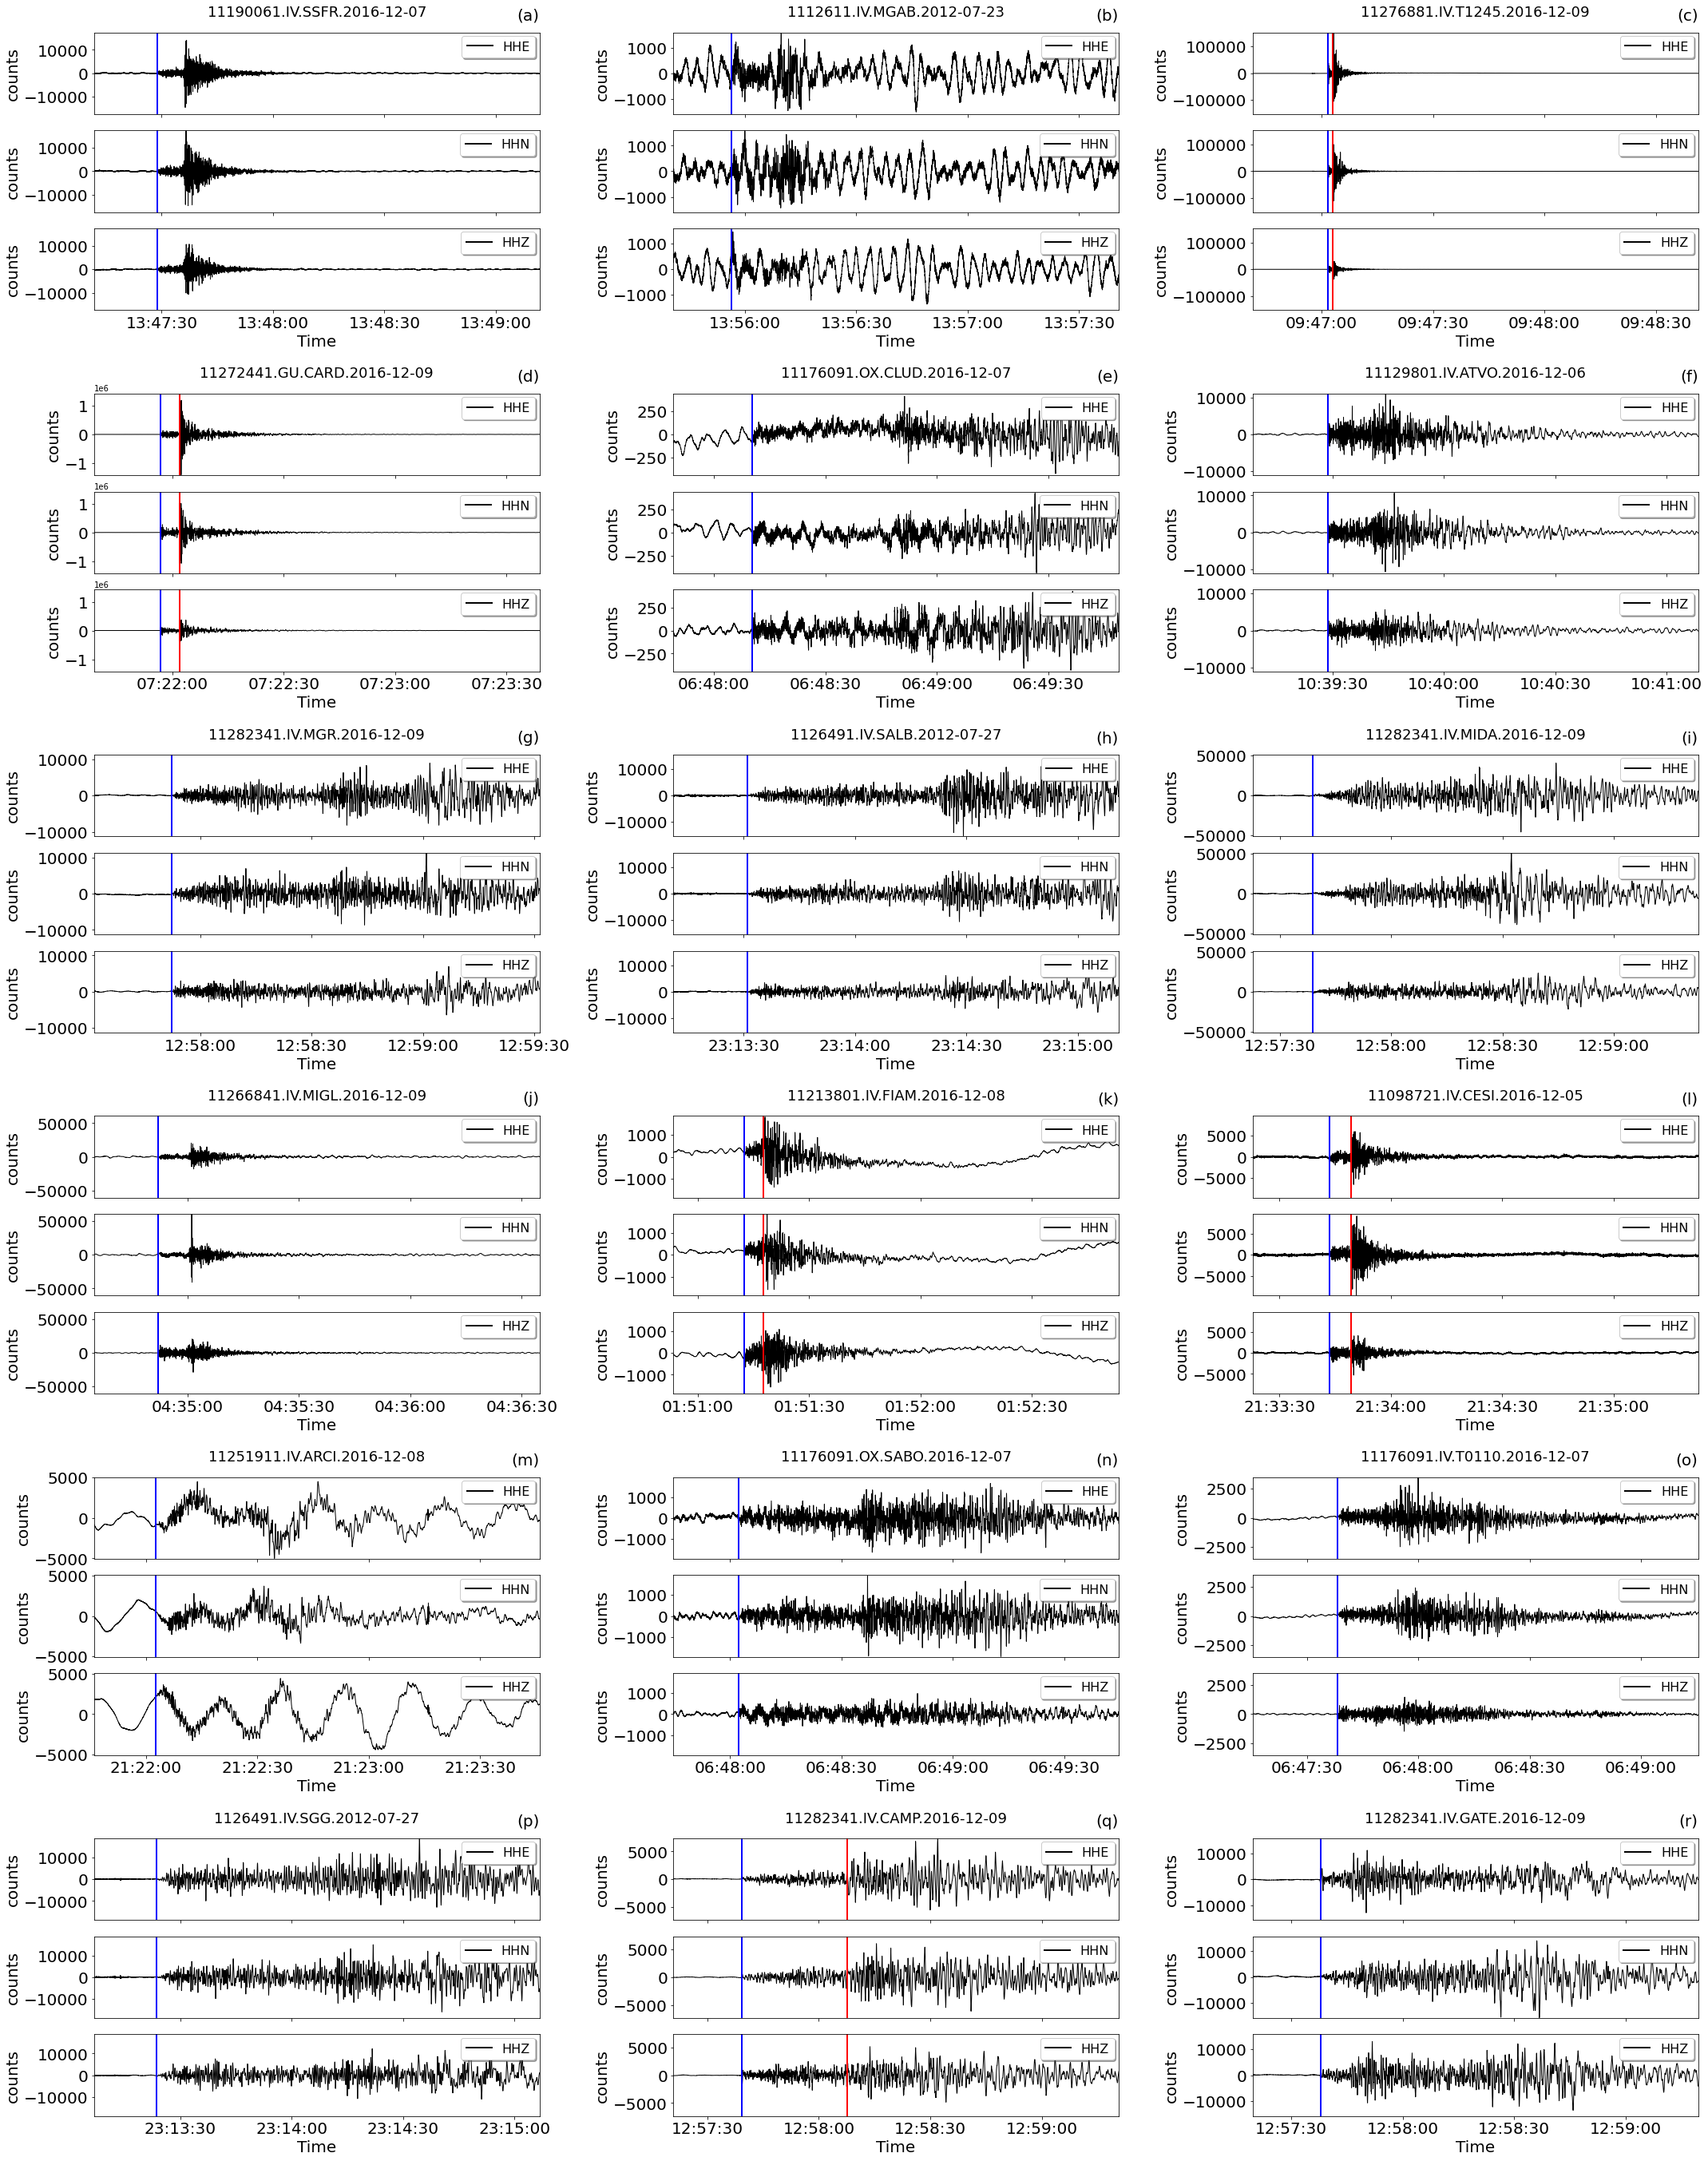

In [30]:
lines = chosen_lines
# Kind of unit
units = len(lines)*["counts"]

# Do you want the traces filtered?
filt = False
freq_min=3.0
freq_max=20.0

nrow=int(len(lines)/plots_line)
ncol=plots_line

labs = alllabs[:(ncol*nrow)]

wftype='ev_c'
if wftype == 'ev_c':
    df = events_metaData
    h5 = events_h5File
elif wftype == 'ev_gm':
    df = events_metaData
    h5 = gm_h5File
elif wftype == 'noise':
    df = noise_metaData
    h5 = noise_h5File

multiple_streams(df,h5,lines,wftype,nrow,ncol,units,labs,filt,freq_min,freq_max)
gm_figname=os.path.join(FIGDIR,'Fig_14.png')
plt.savefig(gm_figname,dpi=300)



# Select waveforms for Figure 15
Example of randomly selected problematic earthquake waveforms of the broadband HH channels. Each row contains threerandomly selected traces drawn according to the following criteria: (a-c) traces with `trace_GPD_[P,S]_number` > 3 (7.96 % of thetotal of the HH channels); (d-f) traces with `trace_EQT_number_detections` > 3 (0.38 % of the total of the HH channels); (g-i) traces `trace_[ENZ]_snr_db` with at least one component in the 10% quantile (18.10 % of the total of the HH channels); (j-l) traces with all `trace_[ENZ]_median_counts` either in the first 10% or the last 10% quantiles (5.90 % of the total of the HH channels); (m-o) traces with `trace_[ENZ]_median_counts` either in the first 10% or the last 10% quantiles and corresponding `trace_[ENZ]_snr_db` excluded from the first quartile (5.06 % HH dataset). The arrival times of P- and S-wave onsets are shown by blue and red vertical lines,respectively.

In [31]:
cha = 'HH'

In [32]:
# TOTAL = events_metaData.shape[0]
TOTAL = events_metaData.loc[events_metaData.station_channels == cha].shape[0]
TOTAL

3893

### Define selection criteria based on metadata statistics

In [33]:
df_tmp = events_metaData.loc[(events_metaData.station_channels == cha)]
percents = [0.1, 0.25, 0.75, 0.9]
df_tmp[['trace_E_median_counts','trace_N_median_counts','trace_Z_median_counts',
        'trace_E_snr_db','trace_N_snr_db','trace_Z_snr_db' ,
        'trace_E_rms_counts', 'trace_N_rms_counts','trace_Z_rms_counts']].describe(percentiles=percents)

,trace_E_median_counts,trace_N_median_counts,trace_Z_median_counts,trace_E_snr_db,trace_N_snr_db,trace_Z_snr_db,trace_E_rms_counts,trace_N_rms_counts,trace_Z_rms_counts
count,3893.000000,3893.000000,3893.000000,3886.000000,3886.000000,3886.000000,3893.000000,3893.000000,3.893000e+03
mean,26.008862,7.812741,68.759954,20.119065,20.280529,18.125744,2746.800319,2773.775523,2.051061e+03
std,1669.505451,760.585669,4398.266715,14.071459,13.959102,13.420478,12530.073958,9827.570266,2.517532e+04
min,-6622.000000,-13263.000000,-10247.500000,-13.440470,-13.249896,-13.879028,17.814718,15.978491,1.653521e+01
10%,-32.000000,-32.000000,-12.000000,3.309558,3.491138,2.583829,102.565152,101.953430,5.877876e+01
25%,-7.000000,-8.000000,-2.000000,9.337772,9.376121,7.658003,203.568631,205.588313,1.297846e+02
50%,0.000000,0.000000,0.000000,18.120288,18.608185,16.216453,517.637210,529.269350,3.177163e+02
75%,7.000000,8.000000,3.000000,29.238424,29.569234,26.501679,1627.774097,1634.950136,9.819552e+02
90%,32.000000,34.000000,12.000000,39.694378,39.754478,36.505801,5213.680651,5177.258972,3.197054e+03
max,102677.500000,37610.500000,273372.000000,74.336617,73.574390,68.742970,583182.284666,246606.517802,1.535769e+06


In [34]:
chosen_lines = []
plots_line = 3

#### 1) select earthquakes with `trace_GPD_[P,S]_number` > 3 and `station_channels` = 'HH'

In [35]:
df_tmp = events_metaData.loc[((events_metaData.trace_GPD_P_number > 3) | (events_metaData.trace_GPD_S_number > 3)) & 
                    (events_metaData.station_channels == cha)]
#
ntot = df_tmp.shape[0]
print ("N records: ", ntot, "% total: ", float(ntot/TOTAL * 100.))
#
if ntot > 0:
    lista = list(df_tmp.sample(n=plots_line, random_state=1).index)
    chosen_lines = chosen_lines + lista
    chosen_lines
else:
    print('no waveform found')

N records:  1291 % total:  33.1620857950167


#### 2) select earthquakes with `trace_EQT_number_detections` > 3 and `station_channels` = 'HH'

In [36]:
df_tmp = events_metaData.loc[(events_metaData.trace_EQT_number_detections > 3) & 
                    (events_metaData.station_channels == cha)]
#
ntot = df_tmp.shape[0]
print ("N records: ", ntot, "% total: ", float(ntot/TOTAL * 100.))
#
if ntot > 0:
    lista = list(df_tmp.sample(n=plots_line, random_state=1).index)
    chosen_lines = chosen_lines + lista
    chosen_lines
else:
    print('no waveform found')

N records:  51 % total:  1.3100436681222707


#### 3) select earthquakes with at least one component `trace_[ENZ]_snr_db` in the 10% quantile and `station_channels` = 'HH'

In [37]:
snrv_E, snrv_N, snrv_Z = (2.313, 2.297, 1.2118)
df_tmp = events_metaData.loc[((events_metaData.trace_E_snr_db < snrv_E)| (events_metaData.trace_N_snr_db < snrv_N) | (events_metaData.trace_Z_snr_db < snrv_Z))
                      & (events_metaData.station_channels == cha)]
#
ntot = df_tmp.shape[0]
print ("N records: ", ntot, "% total: ", float(ntot/TOTAL * 100.))
#
if ntot > 0:
    lista = list(df_tmp.sample(n=plots_line, random_state=1).index)
    chosen_lines = chosen_lines + lista
    chosen_lines
else:
    print('no waveform found')

N records:  542 % total:  13.922424865142563


#### 4) select earthquakes with `trace_[ENZ]_median_counts` in the 10% or 90% quantile and `station_channels` = 'HH'

In [38]:
min_threv_E, min_threv_N, min_threv_Z = (-22.0, -22.0, -11.5)
max_threv_E, max_threv_N, max_threv_Z = (22.0, 22.5, 12.0)

df_tmp = events_metaData.loc[(((events_metaData.trace_E_median_counts < min_threv_E) | (events_metaData.trace_E_median_counts > max_threv_E)) & 
                    ((events_metaData.trace_N_median_counts < min_threv_N) | (events_metaData.trace_N_median_counts > max_threv_N)) &
                    ((events_metaData.trace_Z_median_counts < min_threv_Z) | (events_metaData.trace_Z_median_counts > max_threv_Z)))  & 
                      (events_metaData.station_channels == cha)]
#
ntot = df_tmp.shape[0]
print ("N records: ", ntot, "% total: ", float(ntot/TOTAL * 100.))
#
if ntot > 0:
    lista = list(df_tmp.sample(n=plots_line, random_state=1).index)
    chosen_lines = chosen_lines + lista
    chosen_lines
else:
    print('no waveform found')

N records:  357 % total:  9.170305676855897


#### 5) select  earthquake  with `trace_[ENZ]_median_counts` in the first and last 10%, `trace_[ENZ]_snr_db` above 25% and `station_channels` = 'HH'

In [39]:
# 10%
min_threv_E, min_threv_N, min_threv_Z = (-22.0, -22.0, -11.5)
max_threv_E, max_threv_N, max_threv_Z = (22.0, 22.5, 12.0)

# 25%
snrv_E, snrv_N, snrv_Z = (7.29, 7.273, 5.506)

df_tmp = events_metaData.loc[(((events_metaData.trace_E_median_counts < min_threv_E) | (events_metaData.trace_E_median_counts > max_threv_E)) & 
                    ((events_metaData.trace_N_median_counts < min_threv_N) | (events_metaData.trace_N_median_counts > max_threv_N)) &
                    ((events_metaData.trace_Z_median_counts < min_threv_Z) | (events_metaData.trace_Z_median_counts > max_threv_Z)))  &
                    ((events_metaData.trace_E_snr_db > snrv_E) | (events_metaData.trace_N_snr_db > snrv_N) | (events_metaData.trace_Z_snr_db > snrv_Z)) &
                      (events_metaData.station_channels == cha)]
#
ntot = df_tmp.shape[0]
print ("N records: ", ntot, "% total: ", float(ntot/TOTAL * 100.))
#
if ntot > 0:
    lista = list(df_tmp.sample(n=plots_line, random_state=1).index)
    chosen_lines = chosen_lines + lista
    chosen_lines
else:
    print('no waveform found')

N records:  299 % total:  7.680452093501156


## Plot waveforms in Counts

In [ ]:
lines = chosen_lines
# Kind of unit
units = len(lines)*["counts"]

# Do you want the traces filtered?
filt = False
freq_min=3.0
freq_max=20.0

nrow=int(len(lines)/plots_line)
ncol=plots_line

labs = alllabs[:(ncol*nrow)]
wftype = 'ev_c'
if wftype == 'ev_c':
    df = events_metaData
    h5 = events_h5File
elif wftype == 'ev_gm':
    df = events_metaData
    h5 = gm_h5File
elif wftype == 'noise':
    df = noise_metaData
    h5 = noise_h5File


multiple_streams(df,h5,lines,wftype,nrow,ncol,units,labs,filt,freq_min,freq_max)

gm_figname=os.path.join(FIGDIR,'Fig_15.png')
plt.savefig(gm_figname,dpi=300)



/homes/cianetti/INSTANCE/github/instance/notebooks/Def_plot_waveform.py:182: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


# Select waveforms for Figure 16
Example of randomly selected event waveforms in ground motion units of the HH, EH and HN channels in INSTANCE. The traces are representative of 75% of the data and belonging to the second, third and fourth quartiles of each channel. Each row contains three randomly selected traces drawn as follows: (a-f) HH traces with `trace_pga_perc`>5.1e-4 % g; (g-l) EH traces with `trace_pga_perc`>9.3e-4 % g; (m-r) HN traces with `trace_pga_perc`>8.7e-4 % g; The arrival times of P- and S-wave onsets are shown by blue andred vertical lines, respectively

## Select based on PGA  in the 75% of data (i.e., from 25% to 100%)

### 1) HH channels

In [ ]:
cha = 'HH'
df_tmp = events_metaData[(events_metaData['station_channels'].isin([cha]))]

In [ ]:
TOTAL = df_tmp.shape[0]
TOTAL

In [ ]:
# 25%
pgav = 5.1e-4

In [ ]:
chosen_lines = []
plots_line = 3

In [ ]:
neqs = 6
df_tmp = events_metaData.loc[ (events_metaData.trace_pga_perc > pgav) &
                    (events_metaData.station_channels == cha)]

ntot = df_tmp.shape[0]
print ("N records: ", ntot, "% total: ", float(ntot/TOTAL * 100.))
#
if ntot > 0:
    lista = list(df_tmp.sample(n=plots_line, random_state=1).index)
    chosen_lines = chosen_lines + lista
    chosen_lines
else:
    print('no waveform found')

### 2) EH channels

In [ ]:
cha = 'EH'
df_tmp = events_metaData[(events_metaData['station_channels'].isin([cha]))]

In [ ]:
TOTAL = df_tmp.shape[0]
TOTAL

In [ ]:
# 25%
pgav = 9.3e-4

In [ ]:
#
neqs = 6
df_tmp = events_metaData.loc[ (events_metaData.trace_pga_perc > pgav) &
                    (events_metaData.station_channels == cha)]

ntot = df_tmp.shape[0]
print ("N records: ", ntot, "% total: ", float(ntot/TOTAL * 100.))
#
if ntot > 0:
    lista = list(df_tmp.sample(n=plots_line, random_state=1).index)
    chosen_lines = chosen_lines + lista
    chosen_lines
else:
    print('no waveform found')

### 3) HN channels

In [ ]:
cha = 'HN'
df_tmp = events_metaData[(events_metaData['station_channels'].isin([cha]))]


In [ ]:
TOTAL = df_tmp.shape[0]
TOTAL

In [ ]:
# 25%
pgav = 8.7e-4

In [ ]:
#
neqs = 6
df_tmp = events_metaData.loc[(events_metaData.trace_pga_perc > pgav) & 
                            (events_metaData.station_channels == cha)]

ntot = df_tmp.shape[0]
print ("N records: ", ntot, "% total: ", float(ntot/TOTAL * 100.))
#
if ntot > 0:
    lista = list(df_tmp.sample(n=plots_line, random_state=1).index)
    chosen_lines = chosen_lines + lista
    chosen_lines
else:
    print('no waveform found')

# PLOT EVENTS IN GROUND MOTION UNITS

In [ ]:
lines = chosen_lines
# Kind of unit
# units = len(lines)*["$m~s^{-1}$"]
units = ["$m~s^{-1}$","$m~s^{-1}$","$m~s^{-1}$","$m~s^{-1}$","$m~s^{-1}$","$m~s^{-1}$",
         "$m~s^{-1}$","$m~s^{-1}$","$m~s^{-1}$","$m~s^{-1}$","$m~s^{-1}$","$m~s^{-1}$",
         "$m~s^{-2}$","$m~s^{-2}$","$m~s^{-2}$","$m~s^{-2}$","$m~s^{-2}$","$m~s^{-2}$"]

# Do you want the traces filtered?
filt = False
freq_min=3.0
freq_max=20.0

nrow=int(len(lines)/plots_line)

ncol=plots_line
labs = alllabs[:(ncol*nrow)]

wftype = 'ev_gm'
if wftype == 'ev_c':
    df = events_metaData
    h5 = events_h5File
elif wftype == 'ev_gm':
    df = events_metaData
    h5 = gm_h5File
elif wftype == 'noise':
    df = noise_metaData
    h5 = noise_h5File


multiple_streams(df,h5,lines,wftype,nrow,ncol,units,labs,filt,freq_min,freq_max)

figname=os.path.join(FIGDIR,'Fig_16.png')
plt.savefig(figname,dpi=300)



# Select noise waveform for Figure 20
Example   of   randomly   selected   noise   waveforms   of   the   HH   and   EH   channels   contained   in   INSTANCE.   Each row   contains   three   randomly   selected   traces   drawn   according   to   the   following   criteria:   (a-c) `trace_GPD_[P,S]_number`>3   (11.6   %   of   the   total   of   the   EH   channels);   (d-f) `trace_EQT_number_detections`>3   (0.13   %   of   the   total   ofthe  EH  channels);  (g-i)  all  the `trace_[E,N,Z]_rms_counts`<[1013,1071,793]  (86.31  %  of  the  total  of  the  HH  chan-nels);  (j-l)  any  of  the `trace_[E,N,Z]_rms_counts`>[1013,1071,793]  (13.69  %  of  the  total  of  the  HH  channels);  (m-o)  all  the `trace_[E,N,Z]_rms_counts`<[327.1,332,307]  (86.36  %  of  the  total  of  the  EH  channels);  (p-r)  any  of  the `trace_[E,N,Z]_rms_counts`>[327.1,332,307] (13.64 % of the total of the EH channels)

In [ ]:
cha = "HH"

In [ ]:
noise_metaData['trace_E_max'] =  pd.to_numeric(noise_metaData['trace_E_max_counts'], errors='coerce')
noise_metaData['trace_EQT_number_detections'] =  pd.to_numeric(noise_metaData['trace_EQT_number_detections'], errors='coerce')
noise_metaData['trace_GPD_P_number'] =  pd.to_numeric(noise_metaData['trace_GPD_P_number'], errors='coerce')
noise_metaData['trace_GPD_S_number'] =  pd.to_numeric(noise_metaData['trace_GPD_S_number'], errors='coerce')

In [ ]:
TOTAL = noise_metaData.loc[noise_metaData.station_channels == cha].shape[0]
TOTAL

### Define selection criteria based on metadata statistics

In [ ]:
df_tmp = noise_metaData.loc[(noise_metaData.station_channels == cha)]
percents = [0.1, 0.25, 0.75, 0.9]
df_tmp[['trace_E_median_counts','trace_N_median_counts','trace_Z_median_counts',
        'trace_E_rms_counts', 'trace_N_rms_counts','trace_Z_rms_counts']].describe(percentiles=percents)

In [ ]:
cha='EH'

In [ ]:
df_tmp = noise_metaData.loc[(noise_metaData.station_channels == cha)]
percents = [0.1, 0.25, 0.75, 0.9]
df_tmp[['trace_E_median_counts','trace_N_median_counts','trace_Z_median_counts',
        'trace_E_rms_counts', 'trace_N_rms_counts','trace_Z_rms_counts']].describe(percentiles=percents)

In [ ]:
TOTAL = noise_metaData.loc[noise_metaData.station_channels == cha].shape[0]
TOTAL

In [ ]:
chosen_lines = []
plots_line = 3

#### 1) `trace_GPD_[PS]_number` > 3 & `station_channels` = 'EH'

In [ ]:
df_tmp = noise_metaData.loc[((noise_metaData.trace_GPD_P_number > 3) | (noise_metaData.trace_GPD_S_number > 3)) &
                   (noise_metaData.station_channels == cha)]

ntot = df_tmp.shape[0]
print ("N records: ", ntot, "% total: ", float(ntot/TOTAL * 100.))
#
if ntot > 0:
    lista = list(df_tmp.sample(n=plots_line, random_state=1).index)
    chosen_lines = chosen_lines + lista
    chosen_lines
else:
    print('no waveform found')

#### 2) `trace_EQT_number_detection` > 3 & `station_channels` = 'EH'

In [ ]:
df_tmp = noise_metaData.loc[(noise_metaData.trace_EQT_number_detections > 3) & 
                   (noise_metaData.station_channels == cha)]

ntot = df_tmp.shape[0]
print ("N records: ", ntot, "% total: ", float(ntot/TOTAL * 100.))
#
if ntot > 0:
    lista = list(df_tmp.sample(n=plots_line, random_state=1).index)
    chosen_lines = chosen_lines + lista
    chosen_lines
else:
    print('no waveform found')

#### 3) `trace_[E,N,Z]_rms_counts`<[1013,1071,793] & `station_channels` = 'HH'

In [ ]:
cha = 'HH'
TOTAL = noise_metaData.loc[noise_metaData.station_channels == cha].shape[0]
TOTAL

In [ ]:
min_E_rms = 1013
min_N_rms = 1071
min_Z_rms = 793

df_tmp = noise_metaData.loc[((noise_metaData.trace_E_rms_counts <  min_E_rms) & 
                             (noise_metaData.trace_N_rms_counts <  min_N_rms) &
                             (noise_metaData.trace_Z_rms_counts <  min_Z_rms)) &
                             (noise_metaData.station_channels == cha)]

ntot = df_tmp.shape[0]
print ("N records: ", ntot, "% total: ", float(ntot/TOTAL * 100.))
#
if ntot > 0:
    lista = list(df_tmp.sample(n=plots_line, random_state=1).index)
    chosen_lines = chosen_lines + lista
    chosen_lines
else:
    print('no waveform found')

#### 4) at least one of `trace_[E,N,Z]_rms_counts`>[1013,1071,793] & `station_channels` = 'HH'

In [ ]:
df_tmp = noise_metaData.loc[((noise_metaData.trace_E_rms_counts >  min_E_rms) | 
                             (noise_metaData.trace_N_rms_counts >  min_N_rms) |
                             (noise_metaData.trace_Z_rms_counts >  min_Z_rms)) &
                             (noise_metaData.station_channels == cha)]

ntot = df_tmp.shape[0]
print ("N records: ", ntot, "% total: ", float(ntot/TOTAL * 100.))
#
if ntot > 0:
    lista = list(df_tmp.sample(n=plots_line, random_state=1).index)
    chosen_lines = chosen_lines + lista
    chosen_lines
else:
    print('no waveform found')

Selectes # 25221

#### 5) all `trace_[E,N,Z]_rms_counts`<[327.1,332,307] & `station_channels` = 'EH'

In [ ]:
cha = 'EH'
TOTAL = noise_metaData.loc[noise_metaData.station_channels == cha].shape[0]
TOTAL

In [ ]:
min_E_rms = 327.1
min_N_rms = 332
min_Z_rms = 307
df_tmp = noise_metaData.loc[((noise_metaData.trace_E_rms_counts <  min_E_rms) & 
                             (noise_metaData.trace_N_rms_counts <  min_N_rms) &
                             (noise_metaData.trace_Z_rms_counts <  min_Z_rms)) &
                             (noise_metaData.station_channels == cha)]

ntot = df_tmp.shape[0]
print ("N records: ", ntot, "% total: ", float(ntot/TOTAL * 100.))
#
if ntot > 0:
    lista = list(df_tmp.sample(n=plots_line, random_state=1).index)
    chosen_lines = chosen_lines + lista
    chosen_lines
else:
    print('no waveform found')

#### 6) at least one og the `trace_[E,N,Z]_rms_counts`<[327.1,332,307] & `station_channels` = 'EH'

In [ ]:
df_tmp = noise_metaData.loc[((noise_metaData.trace_E_rms_counts >  min_E_rms) | 
                             (noise_metaData.trace_N_rms_counts >  min_N_rms) |
                             (noise_metaData.trace_Z_rms_counts >  min_Z_rms)) &
                             (noise_metaData.station_channels == cha)]

ntot = df_tmp.shape[0]
print ("N records: ", ntot, "% total: ", float(ntot/TOTAL * 100.))
#
if ntot > 0:
    lista = list(df_tmp.sample(n=plots_line, random_state=1).index)
    chosen_lines = chosen_lines + lista
    chosen_lines
else:
    print('no waveform found')

# PLOT NOISE

In [ ]:
lines = chosen_lines
# Kind of unit
units = len(lines)*["Counts"]


# Do you want the traces filtered?
filt = False
freq_min=3.0
freq_max=20.0

nrow=int(len(lines)/plots_line)
ncol=plots_line
labs = alllabs[:(ncol*nrow)]


wftype = 'noise'
if wftype == 'ev_c':
    df = events_metaData
    h5 = events_h5File
elif wftype == 'ev_gm':
    df = events_metaData
    h5 = gm_h5File
elif wftype == 'noise':
    df = noise_metaData
    h5 = noise_h5File


multiple_streams(df,h5,lines,wftype,nrow,ncol,units,labs,filt,freq_min,freq_max)


noise_figname=os.path.join(FIGDIR,'Fig_20.png')
plt.savefig(noise_figname,dpi=300)

